In [1]:
!ls

sample_data


In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#import path
import sys

In [0]:
plt.style.use('seaborn-notebook')

In [4]:
tf.__version__,pd.__version__

('1.13.0-rc1', '0.22.0')

In [0]:
DATA_DIR='https://raw.githubusercontent.com/rajagurunath/PowerGenForecast/master/data/Formatted_data.csv'
electric_df=pd.read_csv(DATA_DIR,sep=';')

In [6]:
electric_df.head()

,DateTime,Wind Speed,Power Generated,Unnamed: 3
0,02-08-2016 00:00,9.80310,86560.0,NaN
1,02-08-2016 00:15,9.86182,84960.0,NaN
2,02-08-2016 00:30,9.92055,80320.0,NaN
3,02-08-2016 00:45,9.57913,77040.0,NaN
4,02-08-2016 01:00,9.23771,73760.0,NaN


In [0]:
electric_df.set_index(pd.to_datetime(electric_df['DateTime']),inplace=True)

In [8]:
electric_df.iloc[:,:-1].isna().sum()

DateTime              0
Wind Speed         5088
Power Generated       0
dtype: int64

## Ploting

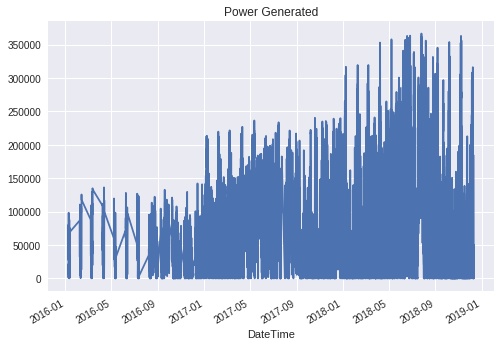

In [9]:
electric_df['Power Generated'].plot(title='Power Generated')
plt.show()

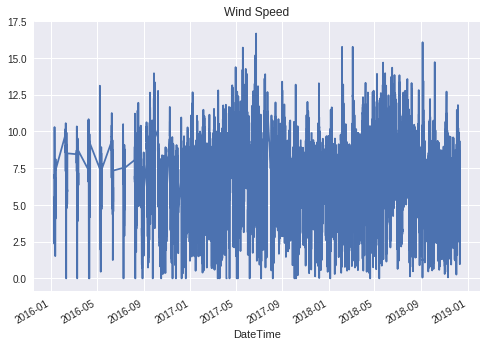

In [10]:
electric_df['Wind Speed'].plot(title='Wind Speed')
plt.show()

# Monthwise

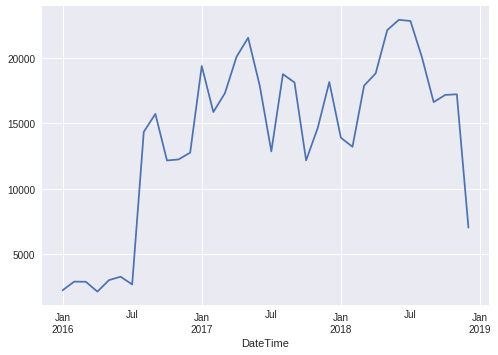

In [11]:
electric_df.resample('1m').sum()['Wind Speed'].plot()

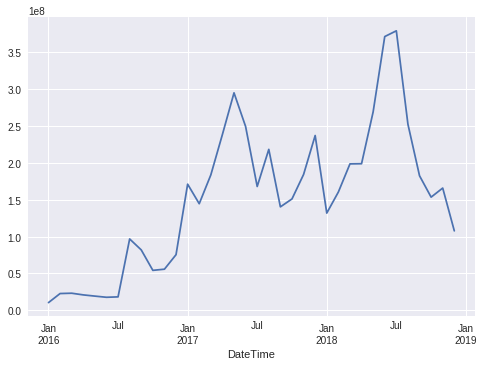

In [12]:
electric_df.resample('1m').sum()['Power Generated'].plot()

# Weekly

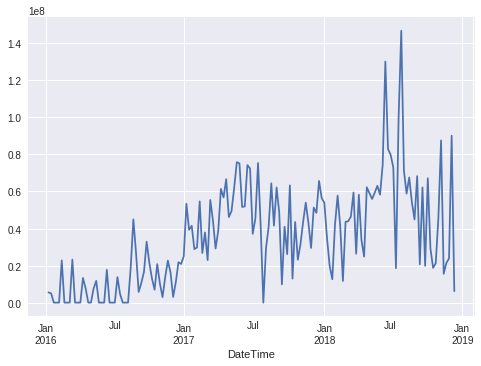

In [13]:
electric_df.resample('1w').sum()['Power Generated'].plot()

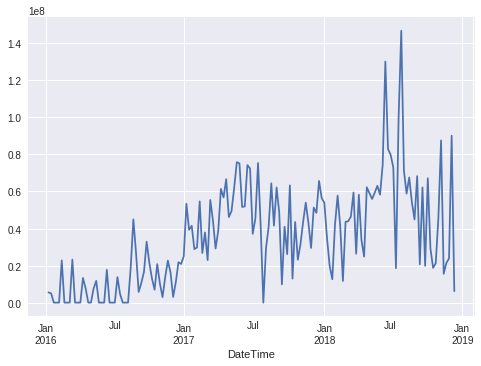

In [14]:
electric_df.resample('1w').sum()['Power Generated'].plot()

# Daywise

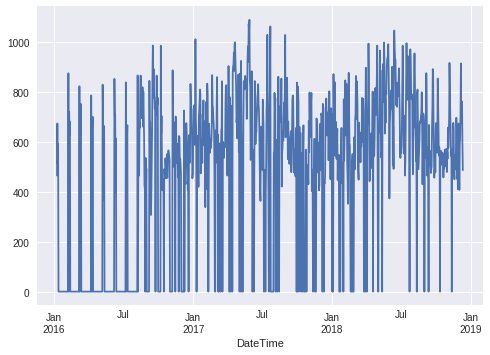

In [15]:
electric_df.resample('1D').sum()['Wind Speed'].plot()

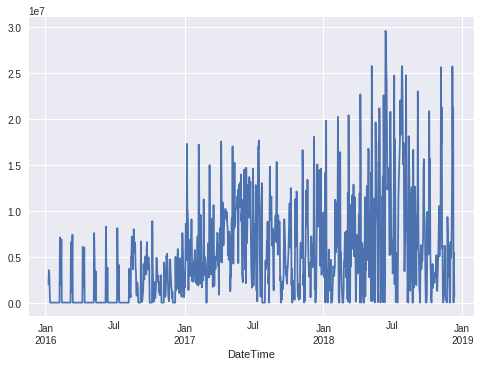

In [16]:
electric_df.resample('1D').sum()['Power Generated'].plot()

# Train -test Split

In [17]:
electric_df['Power Generated'].values.reshape(1,-1)

array([[86560., 84960., 80320., ...,     0.,     0.,     0.]])

In [0]:
from sklearn.preprocessing import StandardScaler,Normalizer
scalar=Normalizer()
electric_df['PowerGenScaled']=scalar.fit_transform(electric_df['Power Generated'].values.reshape(1,-1)).reshape(-1)

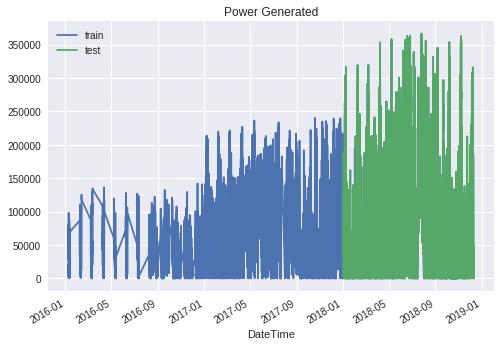

In [19]:
train=electric_df[:'2018-10']
test=electric_df['2018-10':]
train['Power Generated'].plot(label='train')
test['Power Generated'].plot(label='test')
plt.title('Power Generated')
plt.legend()
plt.show()

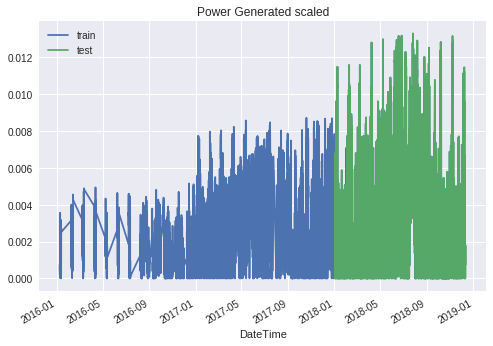

In [20]:
train['PowerGenScaled'].plot(label='train')
test['PowerGenScaled'].plot(label='test')
plt.title('Power Generated scaled')
plt.legend()
plt.show()

# Neural Networks-Model Building

## Approach 1 -Treating power Generated as Sequence

In [0]:
#@title Train config
INP_SEQ = 96 #@param {type:raw}'

OUT_SEQ=96 #@param {type:raw}'

In [0]:
power=train['PowerGenScaled'].values
wind=train['Wind Speed'].values

def powerG():
    inp_l=[]
    out_l=[]
    for i in range(power.shape[0]-(OUT_SEQ)):
        yield (wind[i:i+INP_SEQ].reshape(1,-1),power[i:i+OUT_SEQ].reshape(1,-1))
        
def prepare_data(W,P):
    print(W.shape)
    inp_l=[]
    out_l=[]
    for i in range(W.shape[0]-(OUT_SEQ)):
        inp_l.append(W[i:i+INP_SEQ])
        out_l.append(P[i:i+OUT_SEQ])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y

In [23]:
X,Y=prepare_data(wind,power)

(77527,)


ludwigdf=pd.DataFrame({'inp_ts':[X],'out_ts':[Y]},index=range(len(X)))
ludwigdf.to_csv(DIR+'/ludwig_ts.csv')

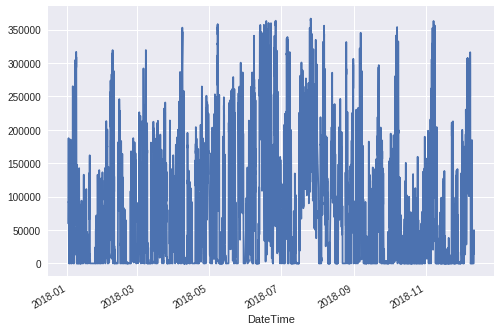

In [24]:
test['Power Generated'][test['Power Generated'].isna()]
test['Power Generated'].plot()

In [0]:
arraytest=test['PowerGenScaled'].values
powertest=train['PowerGenScaled'].values
windtest=train['Wind Speed'].values


def powerGtest(use_as_iter=True):
    if use_as_iter:
        for i in range(powertest.shape[0]-(OUT_SEQ)):
            yield (windtest[i:i+INP_SEQ].reshape(1,-1),powertest[i:i+OUT_SEQ].reshape(1,-1))
def inference():
    inp_l=[]
    out_l=[]
    for i in range(powertest.shape[0]-(OUT_SEQ)):
        inp_l.append(windtest[i:i+INP_SEQ])
        out_l.append(powertest[i:i+OUT_SEQ])
    X=np.array(inp_l)
    Y=np.array(out_l)
    return X,Y
#xt,yt=powerGtest()

In [26]:
dstest=tf.data.Dataset.from_generator(powerGtest,(tf.float32,tf.float32),(tf.TensorShape([1,96]),tf.TensorShape([1,96])))

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [0]:
ds=tf.data.Dataset.from_generator(powerG,(tf.float32,tf.float32),(tf.TensorShape([1,96]),tf.TensorShape([1,96])))

In [28]:
value=ds.make_one_shot_iterator().get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [29]:
sess=tf.Session()
sess.run(value)

(array([[ 9.8031 ,  9.86182,  9.92055,  9.57913,  9.23771,  8.89629,
          8.55488,  8.95808,  9.36129,  9.7645 , 10.1677 ,  9.61261,
          9.05751,  8.50241,  7.94731,  8.1782 ,  8.40909,  8.63998,
          8.63998,  8.83156,  8.79225,  8.75294,  8.71363,  8.35648,
          7.99934,  7.64219,  7.28504,  7.62661,  7.96818,  8.30975,
          8.65132,  8.73708,  8.82284,  8.9086 ,  8.99436,  9.11908,
          9.24379,  9.36851,  9.49322,  9.48109,  9.46896,  9.45683,
          9.4447 ,  9.7119 ,  9.97909, 10.2463 , 10.5135 , 10.4865 ,
         10.4595 , 10.4325 , 10.4056 , 10.4425 , 10.4794 , 10.5163 ,
         10.5532 , 10.5056 , 10.458  , 10.4105 , 10.3629 , 10.0528 ,
          9.7427 ,  9.43261,  9.12251,  9.11928,  9.11605,  9.11281,
          9.10958,  9.15321,  9.19684,  9.24047,  9.2841 ,  9.4165 ,
          9.5489 ,  9.6813 ,  9.8137 ,  9.84069,  9.86768,  9.89467,
          9.92166,  9.51087,  9.10009,  8.68931,  8.27853,  8.24189,
          8.20526,  8.16863,  8.13

In [0]:
class windToPower(tf.keras.Model):
    def __init__(self, outseq,num_units=192,batch_size=1):
        super().__init__()
        self.outseq = outseq
        self.batch_size=batch_size
        self.cell = tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell',num_units=num_units)
        self.dense = tf.keras.layers.Dense(units=self.outseq)

    def call(self, inputs):
        state = self.cell.zero_state(batch_size=self.batch_size, dtype=tf.float32)
        output,state=self.cell(inputs,state)
        output=self.dense(output)
        return output

In [31]:
lstm=windToPower(num_units=INP_SEQ,outseq=OUT_SEQ)
lstm.compile('adam',loss='mse')

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.


In [32]:
TB=tf.keras.callbacks.TensorBoard('./logs2',histogram_freq=10,write_grads=True,batch_size=32,write_graph=True)
ES=tf.keras.callbacks.EarlyStopping(patience=20)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

MC=tf.keras.callbacks.ModelCheckpoint(filepath,save_weights_only=True)
#lstm.load_weights('./lstm2.h5')
history=lstm.fit(ds,epochs=50,steps_per_epoch=500,validation_data=dstest,validation_steps=10,callbacks=[ES,MC,TB])

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
500/500 [==============================] - 2s 3ms/step - loss: 4.8556e-04 - val_loss: 1.5845e-06
Epoch 2/50
500/500 [==============================] - 1s 2ms/step - loss: 9.8321e-07 - val_loss: 1.5006e-06
Epoch 3/50
500/500 [==============================] - 1s 2ms/step - loss: 1.0085e-06 - val_loss: 3.5580e-06
Epoch 4/50
500/500 [==============================] - 1s 2ms/step - loss: 5.1378e-07 - val_loss: 1.0413e-06
Epoch 5/50
500/500 [==============================] - 1s 2ms/step - loss: 6.2365e-05 - val_loss: 3.0414e-04
Epoch 6/50
500/500 [==============================] - 1s 2ms/step - loss: 6.5493e-05 - val_loss: 1.3185e-04


In [33]:
!ls

logs2					model-ep016-loss0.000-val_loss0.000.h5
model-ep001-loss0.000-val_loss0.000.h5	model-ep017-loss0.000-val_loss0.000.h5
model-ep002-loss0.000-val_loss0.000.h5	model-ep018-loss0.000-val_loss0.000.h5
model-ep003-loss0.000-val_loss0.000.h5	model-ep019-loss0.000-val_loss0.000.h5
model-ep004-loss0.000-val_loss0.000.h5	model-ep020-loss0.000-val_loss0.000.h5
model-ep005-loss0.000-val_loss0.000.h5	model-ep021-loss0.000-val_loss0.000.h5
model-ep006-loss0.000-val_loss0.000.h5	model-ep022-loss0.000-val_loss0.000.h5
model-ep007-loss0.000-val_loss0.000.h5	model-ep023-loss0.000-val_loss0.000.h5
model-ep008-loss0.000-val_loss0.000.h5	model-ep024-loss0.000-val_loss0.000.h5
model-ep009-loss0.000-val_loss0.000.h5	model-ep025-loss0.000-val_loss0.000.h5
model-ep010-loss0.000-val_loss0.000.h5	model-ep026-loss0.000-val_loss0.000.h5
model-ep011-loss0.000-val_loss0.000.h5	model-ep027-loss0.000-val_loss0.000.h5
model-ep012-loss0.000-val_loss0.000.h5	model-ep028-loss0.000-val_loss0.000.h5
model-ep013-los

# Tensorboard visualization

In [34]:
LOG_DIR = 'logs2'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip


--2019-02-24 11:34:43--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.87.35.92, 54.152.127.232, 52.72.245.79, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.87.35.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.80MB/s    in 0.5s    

2019-02-24 11:34:44 (9.80 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


***Tensorboard link ***

In [35]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


http://630efcf5.ngrok.io


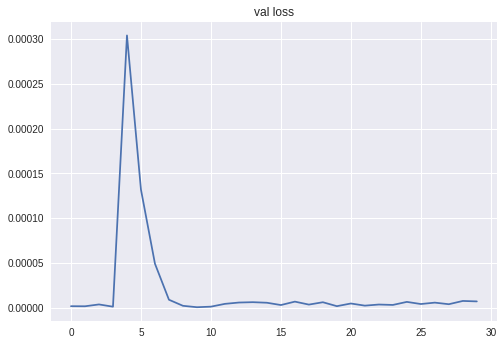

In [36]:
plt.plot(lstm.history.history['val_loss'])
plt.title('val loss')
plt.show()

In [37]:
lstm.evaluate(dstest,steps=1)

1/1 [==============================] - 0s 3ms/step - loss: 4.5454e-06


4.545433966995915e-06

In [0]:
predicted=lstm.predict(dstest,steps=1)

In [39]:
predicted.shape

(1, 96)

# inference or prediction time

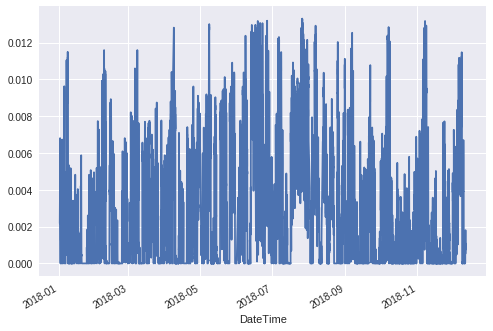

In [40]:
test['PowerGenScaled'].plot()

In [0]:
predicted=lstm.predict_on_batch(dstest)

In [0]:
testiter=dstest.make_one_shot_iterator()
x,y=testiter.get_next()

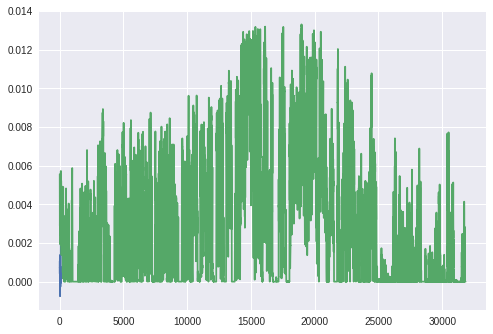

In [43]:
plt.plot(predicted.reshape(-1))
plt.plot(test['PowerGenScaled'].values)
plt.show()

In [0]:
xtest,ytest=inference()
#lstm.predict(X)

In [45]:
xtest.shape,ytest.shape,xtest[0].reshape(1,-1).shape

((77431, 96), (77431, 96), (1, 96))

# *Prediction for last 10 days*

In [0]:
from sklearn.metrics import mean_absolute_error,mean_squared_error


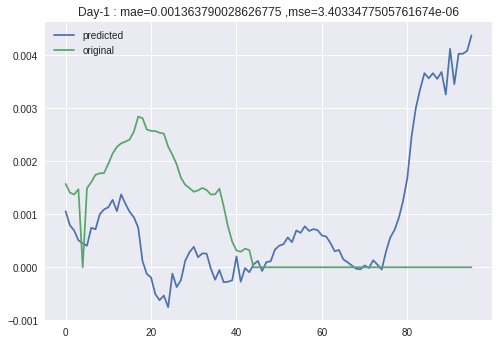

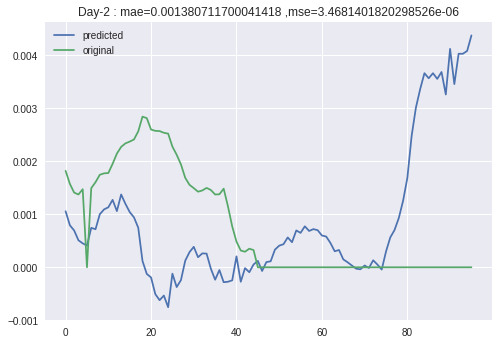

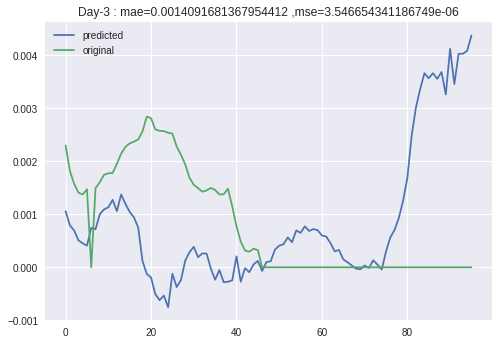

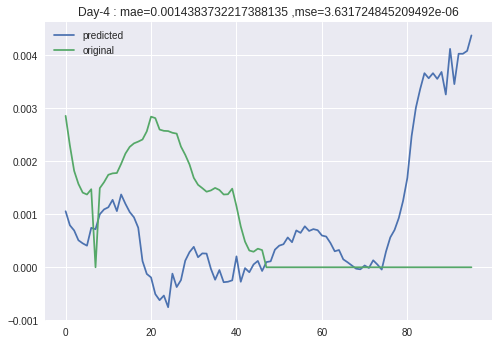

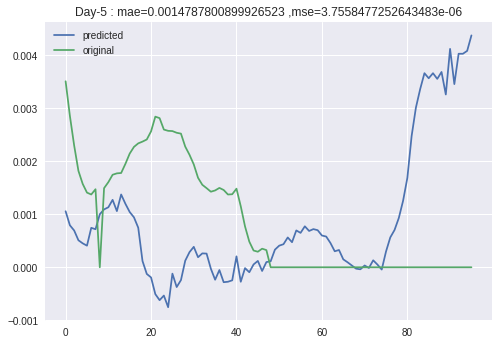

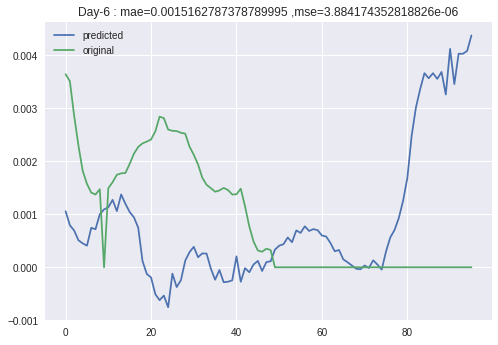

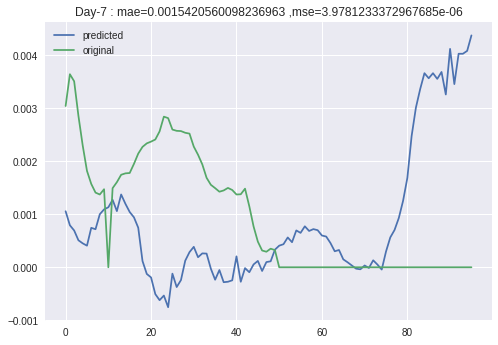

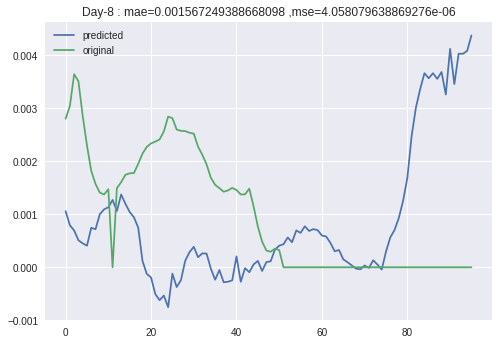

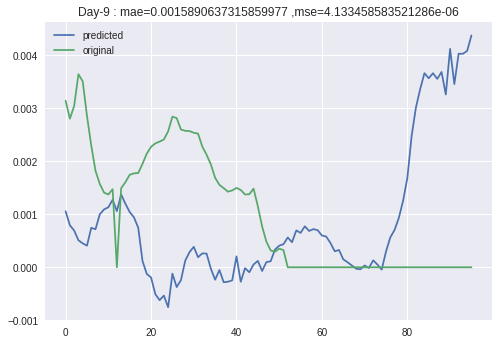

In [47]:
for i in range(1,10):
  ithday=len(xtest)-i
  predicted=lstm.predict(xtest[ithday].reshape(1,-1))
  original=ytest[ithday]
  plt.plot(predicted.reshape(-1),label='predicted')
  plt.plot(original,label='original')
  mae=mean_absolute_error(original,predicted.reshape(-1))
  mse=mean_squared_error(original,predicted.reshape(-1))
  plt.title('Day-{} : mae={} ,mse={}'.format(i,mae,mse))
  plt.legend()
  plt.show()

In [48]:
lstm_est=tf.keras.estimator.model_to_estimator(lstm)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbdda7qdp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb6cf86c9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replica

lstmestimator=tf.keras.estimator.model_to_estimator(keras_model=lstm)